# Install required packages

In [1]:
%pip install transformers datasets
%pip install pandas
%pip install matplotlib
%pip install umap-learn
%pip install datashader bokeh holoviews colorcet scikit-image

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import transformers


/Users/carstenschnober/opt/anaconda3/envs/SoS/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data

In [3]:
from pathlib import Path


DATA_DIR = Path.home() / "Documents" / "SemanticsOfSustainability" / "data" / "Joris"
assert DATA_DIR.is_dir()


In [4]:
ANP_DIR = DATA_DIR / "ANP" / "CleanFiles_perYear"
assert ANP_DIR.is_dir()


## ANP

In [5]:
from tqdm import tqdm


FILE_GLOB = "ANP_19[0-9][0-9].csv.gz"
ENCODING = "iso8859_15"

texts = pd.concat(
    tqdm(
        (
            pd.read_csv(
                f, compression="gzip", sep=";", encoding=ENCODING, parse_dates=["date"]
            ).dropna(subset="content")
            for f in ANP_DIR.glob(FILE_GLOB)
        ),
        total=len(list(ANP_DIR.glob(FILE_GLOB))),
        unit="file",
        desc="Reading",
    ),
    ignore_index=True,
).convert_dtypes()


Reading: 100%|██████████| 47/47 [00:16<00:00,  2.87file/s]


In [6]:
def to_decade(year: int) -> str:
    start = int(year / 10) * 10
    return f"{start} - {start+10}"


texts["decade"] = texts["year"].apply(to_decade)


texts


,filename,content,date,year,month,day,issue,decade
0,anp_1952_01_01_10_ocr.xml,Red.: Datum: veldman 1-1-52 Tijd: 13 ttt^....,1952-01-01,1952,1,1,10,1950 - 1960
1,anp_1952_01_01_11_ocr.xml,Red. Datum: Tijd: Onderwerp: veltmeijer 1...,1952-01-01,1952,1,1,11,1950 - 1960
2,anp_1952_01_01_12_ocr.xml,/3* Red. Datum: Tijd: Onderwerp: veltmei...,1952-01-01,1952,1,1,12,1950 - 1960
3,anp_1952_01_01_13_ocr.xml,Red.: Datum: Tijd: Onderwerp: veltmeijer ...,1952-01-01,1952,1,1,13,1950 - 1960
4,anp_1952_01_01_14_ocr.xml,Red.: Datum: Tijd: Onderwerp: mallon 1-1-...,1952-01-01,1952,1,1,14,1950 - 1960
...,...,...,...,...,...,...,...,...
1472501,anp_1973_12_31_96_ocr.xml,Red.: Datum: Tijd: Onderwerp: kreek 31. 12. 7...,1973-12-31,1973,12,31,96,1970 - 1980
1472502,anp_1973_12_31_97_ocr.xml,Red.: Datum: Tijd: Onderwerp: kuy 31-12-...,1973-12-31,1973,12,31,97,1970 - 1980
1472503,anp_1973_12_31_98_ocr.xml,Red. Datum: Tijd: Onderwerp: kreek 31. 12...,1973-12-31,1973,12,31,98,1970 - 1980
1472504,anp_1973_12_31_99_ocr.xml,Red. Datum: Tijd: Onderwerp: zijl 31-12-...,1973-12-31,1973,12,31,99,1970 - 1980


Text(0, 0.5, 'Number of Documents')

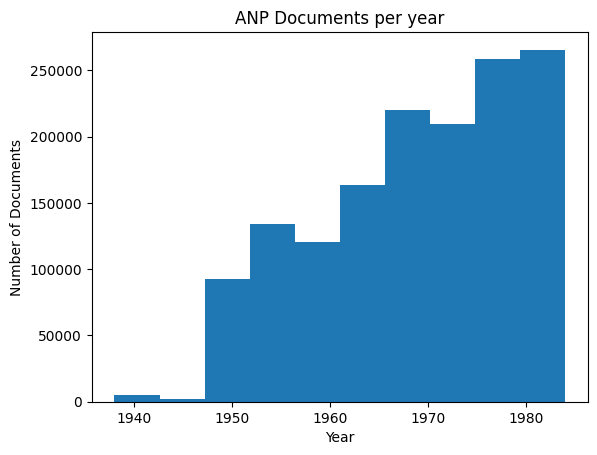

In [7]:
plt.hist(texts.year, label="Year")
plt.title("ANP Documents per year")
plt.xlabel("Year")
plt.ylabel("Number of Documents")


Text(0.5, 0, 'Number of Characters')

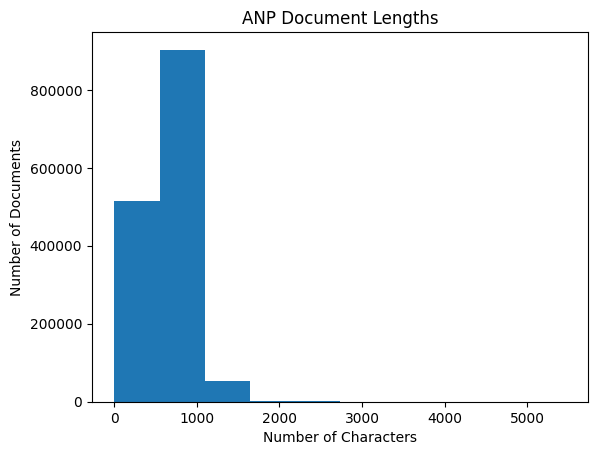

In [8]:
plt.hist(texts.content.str.len())
plt.title("ANP Document Lengths")
plt.ylabel("Number of Documents")
plt.xlabel("Number of Characters")


# Load Model

In [9]:
MODEL_NAME = "DTAI-KULeuven/robbertje-1-gb-non-shuffled"  # NL MODEL TODO: is the model trained on lowercased data?

MODEL_MAX_LENGTH = 512

In [10]:
from transformers import AutoTokenizer, pipeline
from transformers.pipelines.feature_extraction import FeatureExtractionPipeline


tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME, model_max_length=MODEL_MAX_LENGTH, truncation=True
)
# model = RobertaModel.from_pretrained(MODEL_NAME)

# FIXME: cannot use pipeline for extracting layers other than the last one
model: FeatureExtractionPipeline = pipeline(
    "feature-extraction",
    model=MODEL_NAME,
    tokenizer=tokenizer,
    max_length=MODEL_MAX_LENGTH,
    truncation=True,
)


Some weights of the model checkpoint at DTAI-KULeuven/robbertje-1-gb-non-shuffled were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at DTAI-KULeuven/robbertje-1-gb-non-shuffled and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this mode

# Compute Embeddings

In [11]:
TERM = "duurzaam"



In [12]:
term_token_ids = model.tokenizer(TERM)["input_ids"]
print(term_token_ids)

print(model.tokenizer.convert_ids_to_tokens(term_token_ids))


[0, 6395, 4249, 2]
['<s>', 'duur', 'zaam', '</s>']


In [13]:
texts[TERM] = texts.content.str.contains(TERM)


In [14]:
texts.loc[texts[TERM]]


,filename,content,date,year,month,day,issue,decade,duurzaam
3108,anp_1952_02_11_46_ocr.xml,Red.: mallon :-:. raa. üx Datum: 11-2-52 T...,1952-11-02,1952,2,11,46,1950 - 1960,True
15594,anp_1952_07_19_31_ocr.xml,"Red: Kprp, Datum: 19 Juli' 52 Tijd: HOC ...",1952-07-19,1952,7,19,31,1950 - 1960,True
23851,anp_1952_11_03_25_ocr.xml,Red: mallon Datum: 3-*ll?52 Tijd: Onderwe...,1952-03-11,1952,11,3,25,1950 - 1960,True
23861,anp_1952_11_03_34_ocr.xml,Red: Datum: Tijd: Onderwerp: m-llon 3-11...,1952-03-11,1952,11,3,34,1950 - 1960,True
27918,anp_1952_12_29_48_ocr.xml,"Red: Rpmijn Datum: 29 Dec. 52 Tijd: 23, 0...",1952-12-29,1952,12,29,48,1950 - 1960,True
...,...,...,...,...,...,...,...,...,...
1442152,anp_1973_06_16_152_ocr.xml,Red.: Datum: Tijd: Onderwerp: .Leeuw... 1...,1973-06-16,1973,6,16,152,1970 - 1980,True
1442263,anp_1973_06_17_10_ocr.xml,Red.: Datum: Tijd: Onderwerp: duijv . 1....,1973-06-17,1973,6,17,10,1970 - 1980,True
1442313,anp_1973_06_17_1_ocr.xml,Red.: Datum: Tijd: Onderwerp: dujjy 17 6 ...,1973-06-17,1973,6,17,1,1970 - 1980,True
1442332,anp_1973_06_17_37_ocr.xml,Red.: Datum: Tijd: Onderwerp: dujjv 17. ...,1973-06-17,1973,6,17,37,1970 - 1980,True


Text(0, 0.5, 'Number of Documents')

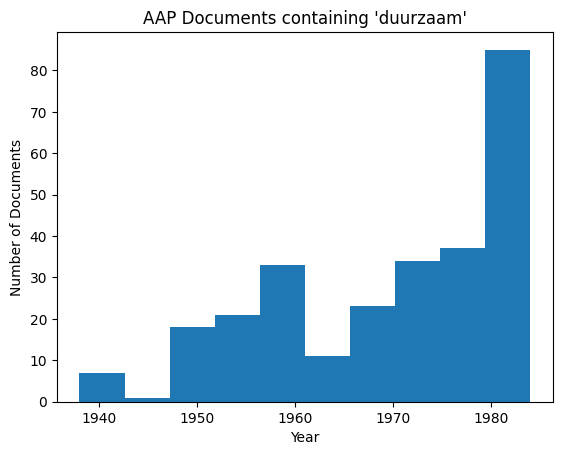

In [15]:
plt.hist(texts.loc[texts.content.str.contains(TERM)].year)
plt.title(f"AAP Documents containing '{TERM}'")
plt.xlabel("Year")
plt.ylabel("Number of Documents")


In [16]:
import importlib
import src

importlib.reload(src)

from src import Sentence

# TODO: split sentences for better embeddings and for handling longer texts

texts.loc[texts[TERM], "Sentence"] = texts.loc[texts[TERM]].apply(
    lambda row: Sentence(row["content"], model, row["year"], row["filename"]),
    axis=1,
)

texts["Sentence"].dropna()


3108       Sentence(text=' Red.: mallon :-:. raa. üx  Dat...
15594      Sentence(text=" Red:  Kprp,  Datum:  19 Juli' ...
23851      Sentence(text=' Red:  mallon  Datum:  3-*ll?52...
23861      Sentence(text=' Red:  Datum:  Tijd:  Onderwerp...
27918      Sentence(text=' Red:  Rpmijn  Datum:  29 Dec. ...
                                 ...                        
1442152    Sentence(text=" Red.:  Datum:  Tijd:  Onderwer...
1442263    Sentence(text=" Red.:  Datum:  Tijd:  Onderwer...
1442313    Sentence(text=' Red.:  Datum:  Tijd: Onderwerp...
1442332    Sentence(text=' Red.:  Datum:  Tijd:  Onderwer...
1452056    Sentence(text=' Red.:  Datum:  Tijd:  Onderwer...
Name: Sentence, Length: 270, dtype: object

In [21]:
texts["embeddings"] = texts.loc[texts["Sentence"].notna(), "Sentence"].apply(
    lambda s: s.embeddings_matrix(TERM)
)
texts["embeddings"].dropna()


3108       [[0.4188813269138336, -0.36967822909355164, 0....
15594                                                     []
23851      [[0.12576256692409515, 0.36140355467796326, 0....
23861      [[0.16293135285377502, 0.07791978865861893, 0....
27918                                                     []
                                 ...                        
1442152    [[0.2423732578754425, -0.6394202709197998, 0.2...
1442263    [[-0.6191000938415527, -0.2804802358150482, 0....
1442313    [[0.21491506695747375, 0.5356446504592896, -0....
1442332    [[-0.00537773035466671, 0.46493324637413025, -...
1452056    [[-0.11271455883979797, 0.0527951680123806, 0....
Name: embeddings, Length: 270, dtype: object

In [22]:
# Candidate sentences with no actual matches for the term

texts.loc[texts["embeddings"].str.len() == 0]


,filename,content,date,year,month,day,issue,decade,duurzaam,Sentence,embeddings
15594,anp_1952_07_19_31_ocr.xml,"Red: Kprp, Datum: 19 Juli' 52 Tijd: HOC ...",1952-07-19,1952,7,19,31,1950 - 1960,True,"Sentence(text="" Red: Kprp, Datum: 19 Juli' ...",[]
27918,anp_1952_12_29_48_ocr.xml,"Red: Rpmijn Datum: 29 Dec. 52 Tijd: 23, 0...",1952-12-29,1952,12,29,48,1950 - 1960,True,Sentence(text=' Red: Rpmijn Datum: 29 Dec. ...,[]
28957,anp_1976_01_07_39_ocr.xml,Red.: cas Datum: 7-1-76 Tijd: Onderwerp: ...,1976-07-01,1976,1,7,39,1970 - 1980,True,Sentence(text=' Red.: cas Datum: 7-1-76 Tijd...,[]
83532,anp_1968_02_22_59_ocr.xml,Red.: Datu m: Tijd: Onderwerp: ..meij. e...,1968-02-22,1968,2,22,59,1960 - 1970,True,Sentence(text=' Red.: Datu m: Tijd: Onderw...,[]
159960,anp_1950_04_12_47_ocr.xml,Cremers 18 eVl9 uur 12. 4. 50 Het vorig jaar ...,1950-12-04,1950,4,12,47,1950 - 1960,True,Sentence(text=' Cremers 18 eVl9 uur 12. 4. 50 ...,[]
171251,anp_1950_09_03_61_ocr.xml,Cremers zondagweekoverzicht 3. 9*50 Het bese...,1950-03-09,1950,9,3,61,1950 - 1960,True,"Sentence(text="" Cremers zondagweekoverzicht 3....",[]
338005,anp_1983_02_10_117_ocr.xml,Red.: ser Datum: 10-2-83 Tijd: 11. 00 Ond...,1983-10-02,1983,2,10,117,1980 - 1990,True,Sentence(text=' Red.: ser Datum: 10-2-83 Ti...,[]
338103,anp_1983_02_10_53_ocr.xml,Red. ser Datum: 10-2-83 Tijd: 11. 00 Onde...,1983-10-02,1983,2,10,53,1980 - 1990,True,Sentence(text=' Red. ser Datum: 10-2-83 Tij...,[]
362737,anp_1983_07_09_15_ocr.xml,^ Red. Datum: Tijd: Onderwerp: kuy 9-7-...,1983-09-07,1983,7,9,15,1980 - 1990,True,Sentence(text=' ^ Red. Datum: Tijd: Onderw...,[]
363292,anp_1983_07_13_128_ocr.xml,Red.: Datum: Tijd: Onderwerp: spa 13 7 83 !<....,1983-07-13,1983,7,13,128,1980 - 1990,True,Sentence(text=' Red.: Datum: Tijd: Onderwerp: ...,[]


In [23]:
indices = []
embeddings = []

# TODO: optimize

for row in texts.loc[texts.Sentence.notna()].itertuples():
    for embedding in row.Sentence.embeddings_matrix(TERM):
        indices.append(row.Index)
        embeddings.append(embedding)


In [24]:
embeddings = np.array(embeddings)

assert embeddings.shape[1] == model.model.config.hidden_size

embeddings.shape

(262, 768)

# Plot

In [25]:
import umap.plot

umap.plot.output_notebook()

title = f"UMAP Embeddings Projections for '{TERM}'"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Loading BokehJS ...

In [26]:
mapper = umap.UMAP().fit(embeddings)


In [27]:
texts.loc[indices, "x"] = mapper.embedding_[:, 0]
texts.loc[indices, "y"] = mapper.embedding_[:, 1]
texts.loc[indices]


,filename,content,date,year,month,day,issue,decade,duurzaam,Sentence,embeddings,x,y
3108,anp_1952_02_11_46_ocr.xml,Red.: mallon :-:. raa. üx Datum: 11-2-52 T...,1952-11-02,1952,2,11,46,1950 - 1960,True,Sentence(text=' Red.: mallon :-:. raa. üx Dat...,"[[0.4188813269138336, -0.36967822909355164, 0....",1.533784,1.542177
3108,anp_1952_02_11_46_ocr.xml,Red.: mallon :-:. raa. üx Datum: 11-2-52 T...,1952-11-02,1952,2,11,46,1950 - 1960,True,Sentence(text=' Red.: mallon :-:. raa. üx Dat...,"[[0.4188813269138336, -0.36967822909355164, 0....",1.533784,1.542177
23851,anp_1952_11_03_25_ocr.xml,Red: mallon Datum: 3-*ll?52 Tijd: Onderwe...,1952-03-11,1952,11,3,25,1950 - 1960,True,Sentence(text=' Red: mallon Datum: 3-*ll?52...,"[[0.12576256692409515, 0.36140355467796326, 0....",4.771782,4.190976
23861,anp_1952_11_03_34_ocr.xml,Red: Datum: Tijd: Onderwerp: m-llon 3-11...,1952-03-11,1952,11,3,34,1950 - 1960,True,Sentence(text=' Red: Datum: Tijd: Onderwerp...,"[[0.16293135285377502, 0.07791978865861893, 0....",4.342077,2.477422
57338,anp_1976_07_27_60_ocr.xml,Red.: aa Datum: 27 7 76 Tijd: 23. 55 On...,1976-07-27,1976,7,27,60,1970 - 1980,True,Sentence(text=' Red.: aa Datum: 27 7 76 Ti...,"[[0.18945671617984772, 0.08487167954444885, -0...",5.854219,6.175853
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1442152,anp_1973_06_16_152_ocr.xml,Red.: Datum: Tijd: Onderwerp: .Leeuw... 1...,1973-06-16,1973,6,16,152,1970 - 1980,True,"Sentence(text="" Red.: Datum: Tijd: Onderwer...","[[0.2423732578754425, -0.6394202709197998, 0.2...",1.995091,2.222697
1442263,anp_1973_06_17_10_ocr.xml,Red.: Datum: Tijd: Onderwerp: duijv . 1....,1973-06-17,1973,6,17,10,1970 - 1980,True,"Sentence(text="" Red.: Datum: Tijd: Onderwer...","[[-0.6191000938415527, -0.2804802358150482, 0....",4.011091,2.219253
1442313,anp_1973_06_17_1_ocr.xml,Red.: Datum: Tijd: Onderwerp: dujjy 17 6 ...,1973-06-17,1973,6,17,1,1970 - 1980,True,Sentence(text=' Red.: Datum: Tijd: Onderwerp...,"[[0.21491506695747375, 0.5356446504592896, -0....",4.424353,5.206059
1442332,anp_1973_06_17_37_ocr.xml,Red.: Datum: Tijd: Onderwerp: dujjv 17. ...,1973-06-17,1973,6,17,37,1970 - 1980,True,Sentence(text=' Red.: Datum: Tijd: Onderwer...,"[[-0.00537773035466671, 0.46493324637413025, -...",4.468647,5.254355


## Static

Text(0.5, 1.0, "UMAP Embeddings Projections for 'duurzaam'")

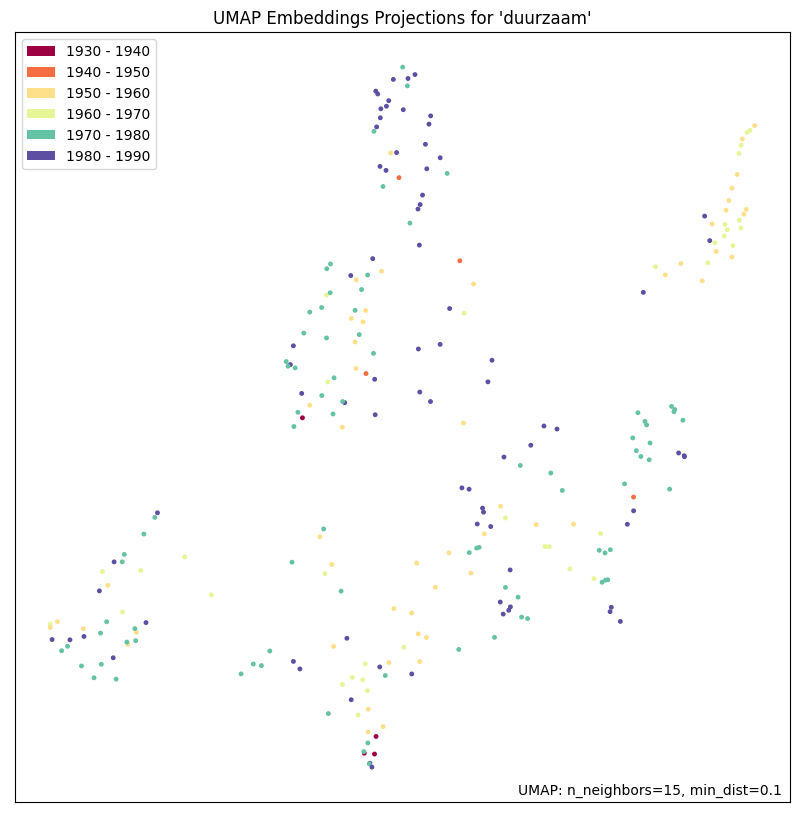

In [28]:
subplot = umap.plot.points(mapper, height=1000, width=1000, labels=texts.loc[indices]["decade"])
subplot.set_title(title)


## Interactive

In [29]:
from bokeh.models import ColumnDataSource

df = texts.loc[indices][["content", "year", "filename", "decade", "x", "y"]]
source = ColumnDataSource(data=df)
df


,content,year,filename,decade,x,y
3108,Red.: mallon :-:. raa. üx Datum: 11-2-52 T...,1952,anp_1952_02_11_46_ocr.xml,1950 - 1960,1.533784,1.542177
3108,Red.: mallon :-:. raa. üx Datum: 11-2-52 T...,1952,anp_1952_02_11_46_ocr.xml,1950 - 1960,1.533784,1.542177
23851,Red: mallon Datum: 3-*ll?52 Tijd: Onderwe...,1952,anp_1952_11_03_25_ocr.xml,1950 - 1960,4.771782,4.190976
23861,Red: Datum: Tijd: Onderwerp: m-llon 3-11...,1952,anp_1952_11_03_34_ocr.xml,1950 - 1960,4.342077,2.477422
57338,Red.: aa Datum: 27 7 76 Tijd: 23. 55 On...,1976,anp_1976_07_27_60_ocr.xml,1970 - 1980,5.854219,6.175853
...,...,...,...,...,...,...
1442152,Red.: Datum: Tijd: Onderwerp: .Leeuw... 1...,1973,anp_1973_06_16_152_ocr.xml,1970 - 1980,1.995091,2.222697
1442263,Red.: Datum: Tijd: Onderwerp: duijv . 1....,1973,anp_1973_06_17_10_ocr.xml,1970 - 1980,4.011091,2.219253
1442313,Red.: Datum: Tijd: Onderwerp: dujjy 17 6 ...,1973,anp_1973_06_17_1_ocr.xml,1970 - 1980,4.424353,5.206059
1442332,Red.: Datum: Tijd: Onderwerp: dujjv 17. ...,1973,anp_1973_06_17_37_ocr.xml,1970 - 1980,4.468647,5.254355


In [30]:
from bokeh.palettes import d3
from bokeh.models import CategoricalColorMapper
import bokeh.palettes

categories = texts.decade.unique()
palette = bokeh.palettes.Category20[len(categories)]

assert len(palette) >= len(
    categories
), f"Palette has only {len(palette)} categories, but {len(categories)} needed."

color_mapper = CategoricalColorMapper(
    factors=[str(c) for c in categories], palette=palette
)
color_mapper


CategoricalColorMapper(id='1004', ...)

In [42]:
from bokeh.models.tickers import SingleIntervalTicker
from bokeh.plotting import figure, show

p = figure(
    height=1000,
    width=1000,
    tooltips=[("filename", "@filename"), ("content", "@content"), ("year", "@year")],
)
p.title = title

# TODO: group by decade to enable muting decades individually via legend
p.dot(
    x="x",
    y="y",
    legend_field="decade",
    source=source,
    size=20,
    color={"field": "decade", "transform": color_mapper},
)

p.legend.click_policy = "mute"


p.xaxis.ticker = SingleIntervalTicker(desired_num_ticks=0)
p.yaxis.ticker = SingleIntervalTicker(desired_num_ticks=0)

show(p)
